In [1]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3163346 sha256=bedd6d0eb9d0dd6dbdd44554c91c5aed71e392511ff10fd475bb7913ce76e0cd
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


Розробимо  за допомогою бібліотеки surprise рекомендаційну систему.
Використовуємо датасет movielens-100k.

In [19]:
from surprise import Dataset, Reader,SVD,SVDpp,NMF,SlopeOne,KNNBasic
from surprise.model_selection import cross_validate
import matplotlib.pyplot as plt
data = Dataset.load_builtin('ml-100k')

Використовуємо алгоритми SVD, SVDpp, NMF + ще два на власний вибір.
Найкращі параметри для всіх алгоритмів підбираємо за допомогою крос-валідації.

In [22]:
algo_svd = SVD()
algo_svdpp = SVDpp()
algo_NMF = NMF()
algo_slop = SlopeOne()
algo_KNN = KNNBasic()


Крос-валідація використовується для оцінки того, наскільки добре ці алгоритми працюють на вашому датасеті.

In [25]:
crossval_svd = cross_validate(algo_svd,data,measures=['RMSE'], cv = 3, verbose=True)
crossval_svdpp = cross_validate(algo_svdpp,data,measures=['RMSE'], cv = 3, verbose=True)
crossval_NMF = cross_validate(algo_NMF,data,measures=['RMSE'], cv = 3, verbose=True)
crossval_slop = cross_validate(algo_slop,data,measures=['RMSE'], cv = 3, verbose=True)
crossval_KNN = cross_validate(algo_KNN,data,measures=['RMSE'], cv = 3, verbose=True)

Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9418  0.9453  0.9512  0.9461  0.0039  
Fit time          0.62    0.66    0.54    0.61    0.05    
Test time         0.13    0.13    0.22    0.16    0.04    
Evaluating RMSE of algorithm SVDpp on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9286  0.9299  0.9280  0.9288  0.0008  
Fit time          17.30   17.10   17.17   17.19   0.08    
Test time         4.74    4.79    5.01    4.85    0.12    
Evaluating RMSE of algorithm NMF on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9773  0.9734  0.9706  0.9738  0.0028  
Fit time          0.84    0.88    0.69    0.80    0.08    
Test time         0.19    0.19    0.12    0.17    0.03    
Evaluating RMSE of algorithm SlopeOne on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9465  0.95

Обчислимо середнє значення середньоквадратичної помилки RMSE для кожного алгоритму на основі результатів крос-валідації

In [31]:
rmse_svd = crossval_svd['test_rmse'].mean()
rmse_svdpp = crossval_svdpp['test_rmse'].mean()
rmse_NMF = crossval_NMF['test_rmse'].mean()
rmse_slop = crossval_slop['test_rmse'].mean()
rmse_KNN = crossval_KNN['test_rmse'].mean()
print(f"svd:{rmse_svd}")
print(f"svdpp:{rmse_svdpp}")
print(f"nmf:{rmse_NMF}")
print(f"slope:{rmse_slop}")
print(f"knn:{rmse_KNN}")

svd:0.9461247406373845
svdpp:0.9287970467569463
nmf:0.9737928933878947
slope:0.9494021360294861
knn:0.9894254894973261


Візуалізація даних

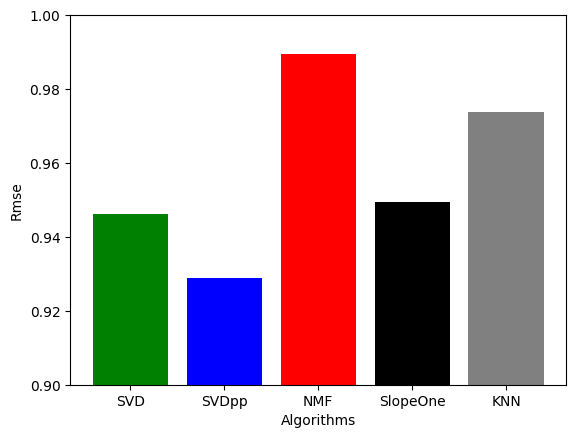

In [33]:
rmse_vals = [rmse_svd,rmse_svdpp,rmse_KNN,rmse_slop,rmse_NMF]
algorithms = ['SVD','SVDpp','NMF','SlopeOne','KNN']
plt.bar(algorithms,rmse_vals,color=['green','blue','red','black','gray'])
plt.xlabel('Algorithms')
plt.ylabel('Rmse')
plt.ylim(0.9,1.0)
plt.show()

Працюємо з алгоритмом SCDpp,також проводимо поділ набору даних.

In [35]:
from surprise import accuracy
from sklearn.metrics import mean_absolute_error
from surprise.model_selection import train_test_split
trainset, testset = train_test_split(data, test_size=.25)
algo_svdpp.fit(trainset)
predictions = algo_svdpp.test(testset)
accuracy.rmse(predictions)

RMSE: 0.9232


0.9232384614642026

In [36]:
from surprise.model_selection import GridSearchCV
param_grid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}
gs = GridSearchCV(SVDpp, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

0.96376380031234
{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}


Імпортуємо токен з сайту

In [37]:
!pip install sigopt
from sigopt import Connection
conn = Connection(client_token="FQAJHXQJZHLSLFODVJXEHAHFYLGPSNBDSEPXNPAULUGNECQE")

Тепер визначаемо параметри

In [38]:
experiment = conn.experiments().create(
  name='Surprise Movies-100k Recommender41',
  parameters=[
    dict(name='n_epochs', type='int', bounds=dict(min=5, max=10)),
    dict(name='lr_all', type='double', bounds=dict(min=0.002, max=0.005)),
    dict(name='reg_all', type='double', bounds=dict(min=0.4, max=0.6))
  ],
  metrics=[
    dict(name='RMSE', objective='minimize', strategy='optimize'),
    dict(name='MAE', objective='minimize', strategy='store')
  ],
  parallel_bandwidth=1,
  observation_budget=50,
)
print("Created experiment: https://app.sigopt.com/experiment/" + experiment.id)

Created experiment: https://app.sigopt.com/experiment/1023676


Визначаємо функції, які необхідні для створення моделі

In [39]:
def create_model(assignments):
  algo = SVDpp(
      n_epochs=assignments['n_epochs'],
      lr_all=assignments['lr_all'],
      reg_all=assignments['reg_all']
  ).fit(trainset)
  return algo

def evaluate_model(assignments):
  algo = create_model(assignments)
  predictions = algo.test(testset)
  return [
      dict(name="RMSE", value=accuracy.rmse(predictions)),
      dict(name="MAE", value=accuracy.mae(predictions))
    ]

Цикл оптимізації

In [40]:
while experiment.progress.observation_count < experiment.observation_budget:
  suggestion = conn.experiments(experiment.id).suggestions().create()
  value_dicts = evaluate_model(suggestion.assignments)
  conn.experiments(experiment.id).observations().create(
    suggestion=suggestion.id,
    values=value_dicts,
  )

  experiment = conn.experiments(experiment.id).fetch()

# Fetch the best configuration and explore your experiment
all_best_assignments = conn.experiments(experiment.id).best_assignments().fetch()
# Returns a list of dict-like Observation objects
best_assignments = all_best_assignments.data[0].assignments
print("Best Assignments: " + str(best_assignments))
print("Explore your experiment: https://app.sigopt.com/experiment/" + experiment.id + "/analysis")

RMSE: 0.9816
MAE:  0.7927
RMSE: 0.9832
MAE:  0.7936
RMSE: 0.9730
MAE:  0.7826
RMSE: 0.9669
MAE:  0.7760
RMSE: 0.9711
MAE:  0.7802
RMSE: 0.9663
MAE:  0.7754
RMSE: 0.9674
MAE:  0.7771
RMSE: 0.9636
MAE:  0.7727
RMSE: 0.9747
MAE:  0.7847
RMSE: 0.9811
MAE:  0.7904
RMSE: 0.9725
MAE:  0.7827
RMSE: 0.9774
MAE:  0.7878
RMSE: 0.9707
MAE:  0.7804
RMSE: 0.9726
MAE:  0.7831
RMSE: 0.9765
MAE:  0.7857
RMSE: 0.9699
MAE:  0.7803
RMSE: 0.9733
MAE:  0.7831
RMSE: 0.9694
MAE:  0.7791
RMSE: 0.9794
MAE:  0.7901
RMSE: 0.9683
MAE:  0.7773
RMSE: 0.9722
MAE:  0.7827
RMSE: 0.9767
MAE:  0.7876
RMSE: 0.9821
MAE:  0.7925
RMSE: 0.9724
MAE:  0.7818
RMSE: 0.9676
MAE:  0.7766
RMSE: 0.9712
MAE:  0.7817
RMSE: 0.9769
MAE:  0.7871
RMSE: 0.9725
MAE:  0.7826
RMSE: 0.9741
MAE:  0.7840
RMSE: 0.9806
MAE:  0.7907
RMSE: 0.9685
MAE:  0.7777
RMSE: 0.9742
MAE:  0.7850
RMSE: 0.9702
MAE:  0.7794
RMSE: 0.9732
MAE:  0.7827
RMSE: 0.9883
MAE:  0.7986
RMSE: 0.9733
MAE:  0.7825
RMSE: 0.9831
MAE:  0.7931
RMSE: 0.9709
MAE:  0.7805
RMSE: 0.9753

/usr/local/lib/python3.10/dist-packages/sigopt/objects.py:338: RuntimeWarning: The .data field only contains a single page of results, which may be incomplete for large responses. Prefer to use the `.iterate_pages() to ensure that you iterate through all elements in the response.
  warnings.warn(


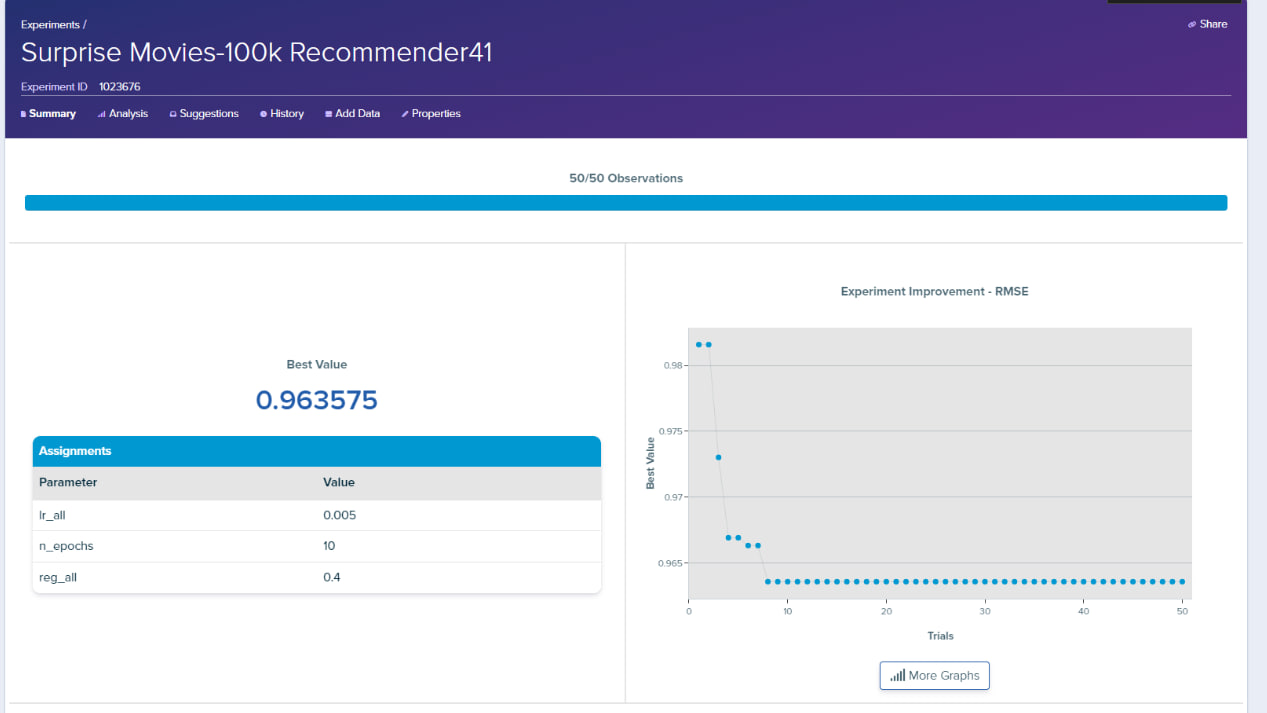

В ході практичної роботи я працював з датасетом movielens-100k, використовував алгоритми SVD, SVDpp, NMF. Обчислив середнє значення середньоквадратичної помилки RMSE, зробив візуалізацію.